In [1]:
from __future__ import print_function
import sys
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
os.chdir("/usr/src/app")

In [2]:
def path_video(video_id):
    return f'videos/{video_id}.mp4'

def capture_frame(cap, frame_num):
    frame = get_frame(cap, frame_num)
    return frame

def get_video(video_path):
    return cv2.VideoCapture(video_path)

def get_frame(cap, frame_num):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    
    # Read the frame
    ret, frame = cap.read()

    return frame

def get_total_frames(cap):
    # Get the total number of frames in the video
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frames

def get_fps_video(cap): 
    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    return fps

def plot_frames_grid(frames, nrows, ncols, size=(14, 11)):
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=size)
    
    # Add content to each subplot (replace this with your data)
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            frame = frames[idx]
            ax = axes[i, j]
            ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            idx += 1
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def plot_frame(frame, size=(14,11)):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=size)
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_net(ax, net_points, frame):
    # Draw the net (rectangle) on the frame in green
    net_points = np.array(net_points, dtype=int)
    cv2.polylines(frame, [net_points], isClosed=True, color=(0, 255, 0), thickness=2)
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return ax

def plot_court(ax, court_points):
    # Extract court points and scatter them as black points
    court_points = np.array(court_points, dtype=int)
    ax.scatter(court_points[:, 0], court_points[:, 1], c='black', s=5)
    return ax

def get_patch(image, court_points, idx, w = 25):
    kp = court_points[idx]
    x,y = kp
    x = int(x); y = int(y)
    patch = image[y-w:y+w, x-w:x+w, :]
    return patch

def patch_image(image, center, w=(25, 25)):
    x,y = center
    wx, wy = w
    x = int(x); y = int(y)
    patch = image[y-wy:y+wy, x-wx:x+wx, :]
    return patch

def match_patch(img, patch, window_template, loc_at_center=True):
    # Template matching
    match_method = cv2.TM_SQDIFF
    result = cv2.matchTemplate(img, patch, match_method)

    # Find the minimum value (best match) and its location
    # this is the top left corner of the box
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    
    # Subtract the width to all tuple elements since we convert
    # top left into the center of the patch
    if loc_at_center:
        match_loc = op_tuples(min_loc, window_template)
    else:
        match_loc = min_loc
    
    return match_loc, min_val

def wrap_match_patch(img, patch, ii):
    return match_patch(img, patch), ii

def eval_match_patch(match_loc, true_loc):
    # Convert the float target center of the patch into integers
    true_loc = tuple(map(lambda x: int(x), true_loc))
    return mse(true_loc, match_loc)

def match_all_patches(img, patches):
    d_match_loc = {}
    with ThreadPoolExecutor(len(patches)) as executor:
        pool_res = [executor.submit(wrap_match_patch, img, patch, idx_patch) for idx_patch, patch in enumerate(patches)]
        for future_res in as_completed(pool_res):
            res_match_patch, idx_patch = future_res.result()
            d_match_loc[idx_patch] = res_match_patch
    return d_match_loc

def op_tuples(tuple1, tuple2, op="add"):
    if op == "add":
        result = tuple(x + y for x, y in zip(tuple1, tuple2))
    elif op == "subtract":
        result = tuple(x - y for x, y in zip(tuple1, tuple2))
    else:
        result = None
    return result

def draw_circle(img, pos, plot=True):
    x_img = img.copy()
    color = (0, 0, 255)
    size = 10
    x_img = cv2.circle(x_img, pos, size, color, -1)
    if plot:
        plot_frame(x_img, size=(8,3))
        return
    return x_img

def from_bgr_to_pil(img):
    # Load and preprocess the first image
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb_img)
    return pil

def get_roi(image, frac_start = 1./6, frac_end = 1./6):
    # Define the region of interest (ROI)
    H, W, _ = image.shape
    roi_start_h = int(H * frac_start)
    roi_end_h = int(H * frac_end)
    roi_start_w = int(W * frac_start)
    roi_end_w = int(W * frac_end)
    return roi_start_h, roi_end_h, roi_start_w, roi_end_w

def get_roi_xy(image, fx_s = 1./6, fx_e = 2./6, fy_s = 1./6, fy_e = 2./6):
    # Define the region of interest (ROI)
    H, W, _ = image.shape
    roi_start_h = int(H * fy_s)
    roi_end_h = int(H * fy_e)
    roi_start_w = int(W * fx_s)
    roi_end_w = int(W * fx_e)
    return roi_start_h, roi_end_h, roi_start_w, roi_end_w

def get_mask_xy(image, fx_s = 1./6, fx_e = 2./6, fy_s = 1./6, fy_e = 2./6):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image,fx_s, fx_e, fy_s, fy_e)
    # Create a mask for the ROI
    mask = np.zeros((H, W), dtype=np.uint8)
    mask[sh:eh, sw:ew] = 255
    return mask

def get_image_mask_xy(image, fx_s, fx_e, fy_s, fy_e):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi_xy(image, fx_s, fx_e, fy_s, fy_e)
    patch = image[sh:eh, sw:ew]
    return patch

def get_mask(image, frac_start, frac_end):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image, frac_start, frac_end)
    # Create a mask for the ROI
    mask = np.zeros((H, W), dtype=np.uint8)
    mask[sh:eh, sw:ew] = 255
    return mask

def get_image_mask(image, frac_start, frac_end):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image, frac_start, frac_end)
    patch = image[sh:eh, sw:ew]
    return patch

def get_hist(image):
    # Compute the histogram
    f_hist = cv2.calcHist(
        images=[image], 
        channels=[0], 
        mask=None, 
        histSize=[30], 
        ranges=[0, 180]
    )
    return f_hist.ravel()

def get_hist_on_patch_masked(image, f1, f2):
    # Convert BGR image to HSV format
    hsv_f_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Generate a mask
    f_mask = get_mask(image, f1, f2)
    
    # Compute the histogram
    f_hist = cv2.calcHist(
        images=[hsv_f_img], 
        channels=[0], 
        mask=f_mask, 
        histSize=[30], 
        ranges=[0, 180]
    )
    return f_hist.ravel()
    
def patch_similarity(patch1, patch2):
    patch1_hist = get_hist(patch1)
    patch2_hist = get_hist(patch2)
    
    # Calculate the Bhattacharyya coefficient
    bc = cv2.compareHist(patch1_hist, patch2_hist, cv2.HISTCMP_BHATTACHARYYA)
    return bc

def patch_similarity_on_template(q_patch, t_hist):
    patch_q_hist = get_hist(q_patch)
    
    # Calculate the Bhattacharyya coefficient
    bc = cv2.compareHist(t_hist, patch_q_hist, cv2.HISTCMP_BHATTACHARYYA)
    return bc

def generate_patches_of_image(image, patches_fractions):
    """
        patches_fractions: includes a tuple (frac_x_start, frac_x_end, frac_y_start, frac_y_end)
    """
    l_fr = []
    for ii in range(len(patches_fractions)):
        fxs, fxe, fys, fye = patches_fractions[ii]
        fr = get_image_mask_xy(image, fxs, fxe, fys, fye)
        l_fr.append(fr)
    return l_fr

def get_bc_conf(list_of_bc_coefficients):
    """
    We will input a list of N elements
    These elements are the patch_similarity_on_template outputs
    These outputs are the similarities of the N patches of query 
    compared to the corresponding patch on the reference image.
    We set two thresholds for the Bhattacharyya coefficients:
    - High (0.3): if the BC coefficient of the comparison
        of the query to the reference of that patch is <0.3
        then we will +1 to the final confidence
    - Low (0.5): if the BC coefficient of the comparison
        of the query to the reference of that patch is <0.5
        then we will +1 to the final confidence
    Since we have N=4 patches, and two thresholds, we
    can opt for a confidence at most of 8 and at minimum of 0
    A confidence of 8 indicates super similar query to reference image in all patches
    """
    THRES_BC_HIGH_CONF = 0.3
    THRES_BC_LOW_CONF = 0.5
    l_bc = np.array(list_of_bc_coefficients)
    n_match_low_conf = np.sum(l_bc < THRES_BC_LOW_CONF)
    n_match_high_conf = np.sum(l_bc < THRES_BC_HIGH_CONF)
    confidence = n_match_low_conf + n_match_high_conf
    return confidence

# Read annotations

In [3]:
PATH_ANNOTATIONS_REFERENCE_PARQUET = "annotations/reference_courts/annotations.parquet"
dfannot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# Select Reference court

In [4]:
tournament_id = 4  # Indian Wells

In [5]:
# Get the reference court points and net points at the given frame number
s = dfannot.loc[dfannot["tournament_id"] == tournament_id].reset_index(drop=True).loc[0]

video_id = s.video_id  # "DhnpBjrgb34"
path = path_video(video_id)
frame_num = s.frame_id
court_points = np.vstack(s.court)
net_points = np.vstack(s.net)
print(f"Video: {video_id}, Frame: {frame_num}, Path: {path}")

Video: fnK4I6k9eHs, Frame: 29533, Path: videos/fnK4I6k9eHs.mp4


### Load frame of reference court

In [6]:
# Open the video file
cap = cv2.VideoCapture(path)

# Load reference frame
t_img = capture_frame(cap, frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

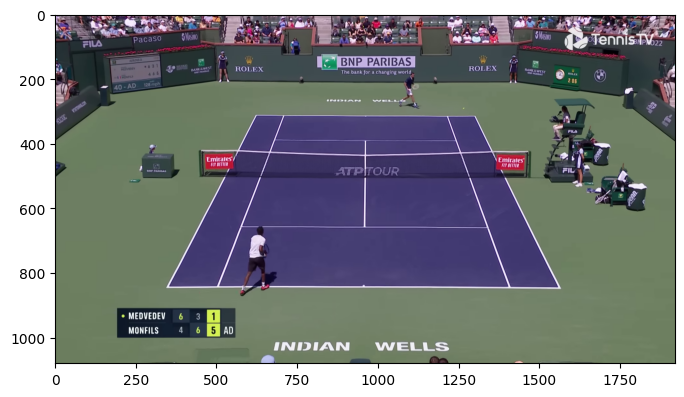

In [7]:
plot_frame(t_img, size=(8,8))

# Select Query court

In [8]:
q_video_id = "jGAMZKj6Ceo"
q_path = path_video(q_video_id)

# Open the video file
cap = cv2.VideoCapture(q_path)

# Get FPS
q_fps = get_fps_video(cap)

# Cosine similarities
# 36s: 0.9564
# 37.8s: 0.9396
# 39.8s: 0.8639 (Sinner image)
 

q_second = 37.8   # 37.8 OK # 36 OK
q_frame_num = int(q_second * q_fps)

In [9]:
# Load query frame
q_img = capture_frame(cap, q_frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

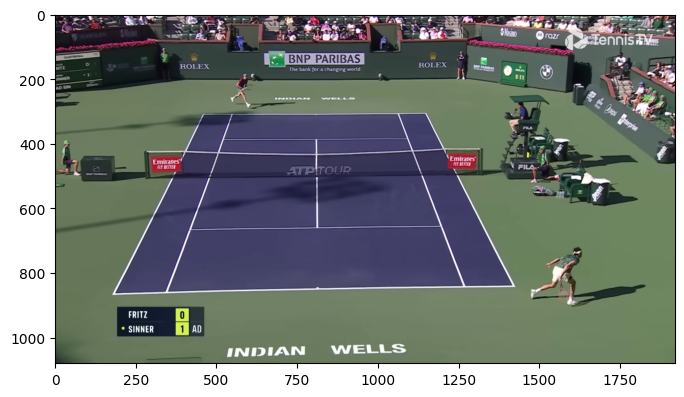

In [10]:
plot_frame(q_img, size=(8,8))

# Histogram Functions

### Patch both images in 4 sub images

In [11]:
# ------------------- #
#  Patches of image
# ------------------- #
fs = [
    (1./7, 1./2, 1./7, 1./2), 
    (1./2, 6./7,  1./7, 1./2),
    (1./7, 1./2, 1./2, 6./7),
    (1./2, 6./7, 1./2, 6./7),  
]

(<Figure size 800x800 with 1 Axes>, <Axes: >)

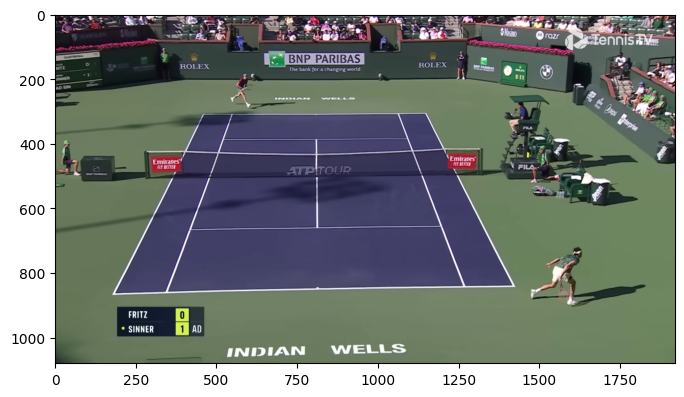

In [12]:
plot_frame(q_img, size=(8,8))

In [13]:
patches_t_img = generate_patches_of_image(t_img, fs)
patches_q_img = generate_patches_of_image(q_img, fs)

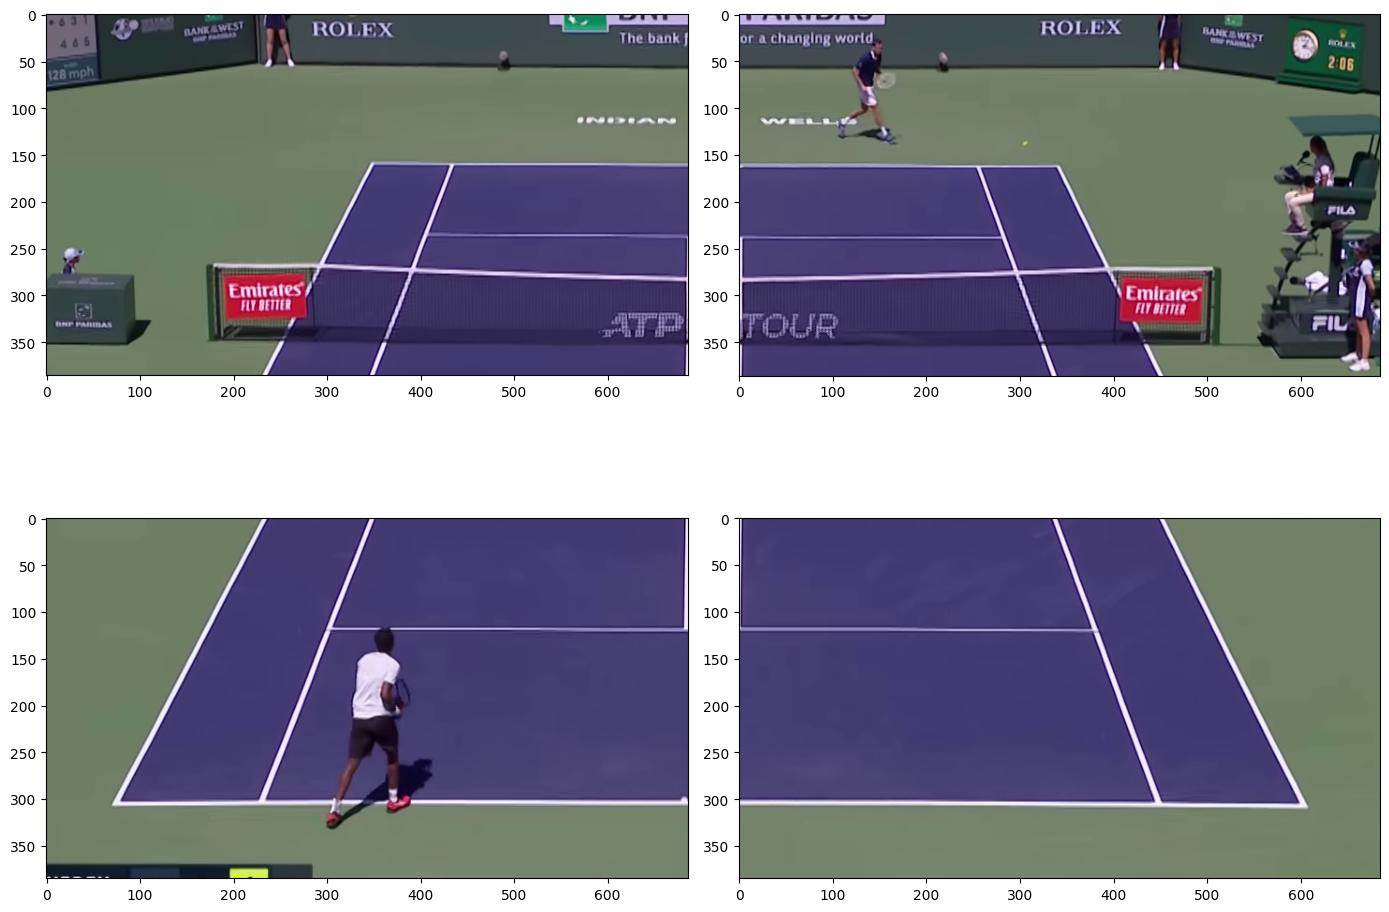

In [14]:
plot_frames_grid(patches_t_img, 2, 2)

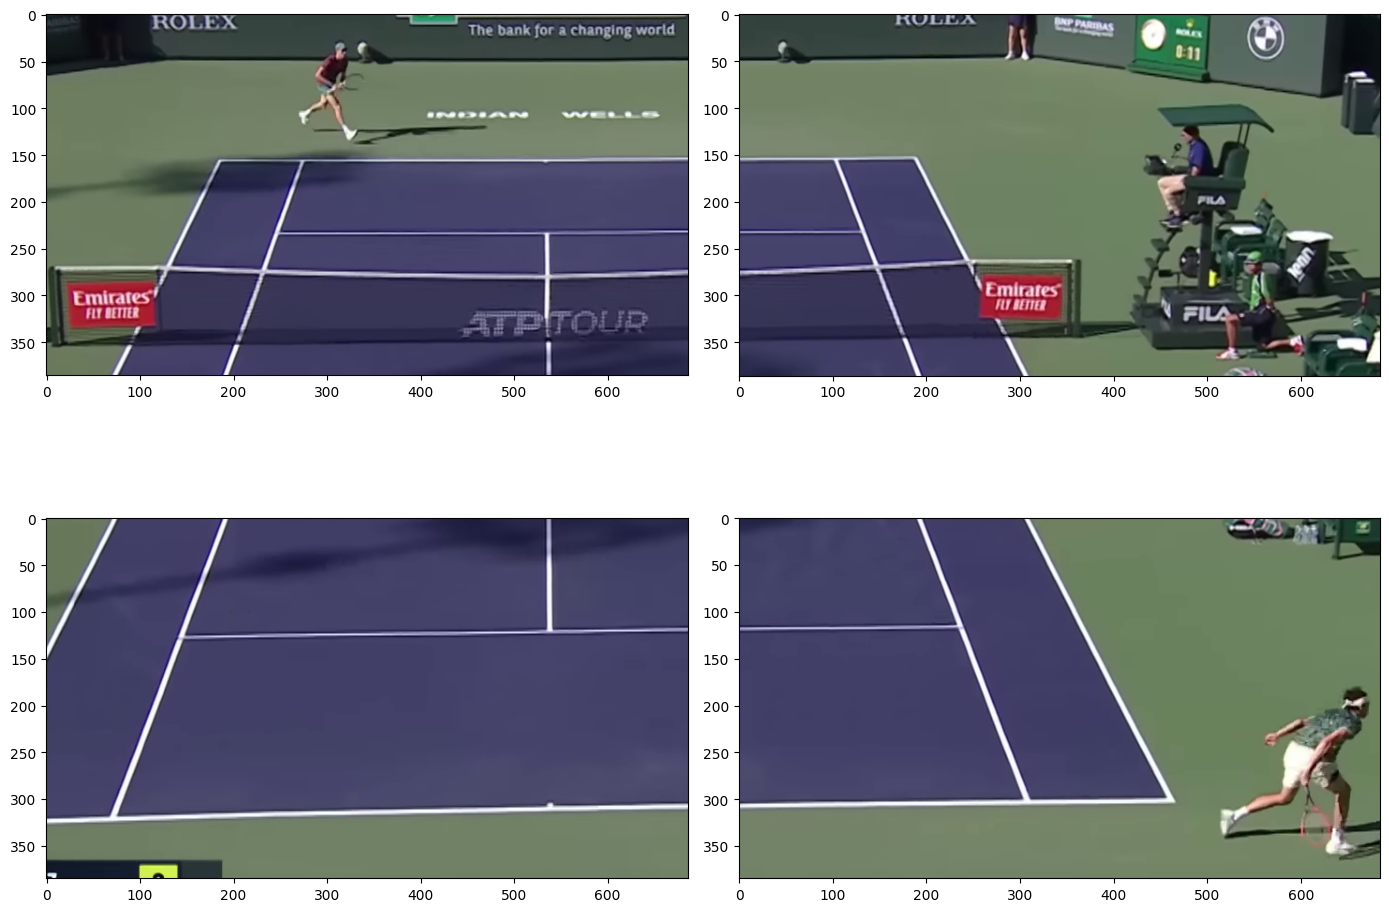

In [15]:
plot_frames_grid(patches_q_img, 2, 2)

### Compare each query patch to the reference template patch

In [16]:
%%time
l_bc = []
for idx in range(len(patches_q_img)):
    bc = patch_similarity(patches_t_img[idx], patches_q_img[idx])
    l_bc.append(bc)

CPU times: user 3.95 ms, sys: 1 ms, total: 4.96 ms
Wall time: 4.72 ms


In [17]:
confidence = get_bc_conf(l_bc)

In [18]:
confidence

3

# Putting all Together

In [19]:
# ---------------------- #
# Inputs
# ---------------------- #
tournament_id = 4  # Indian Wells
q_video_id = "jGAMZKj6Ceo" # "DhnpBjrgb34"

In [20]:
# ------------------- #
#  Constants
# ------------------- #
# Fraction (H and W) to create patches of image
fs = [
    # frac_x_start, frac_x_end, frac_y_start,
    (1./7, 1./2, 1./7, 1./2), 
    (1./2, 6./7,  1./7, 1./2),
    (1./7, 1./2, 1./2, 6./7),
    (1./2, 6./7, 1./2, 6./7),  
]

In [21]:
# ---------------------- #
# Annotations
# ---------------------- #
PATH_ANNOTATIONS_REFERENCE_PARQUET = "annotations/reference_courts/annotations.parquet"
dfannot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# Get the reference court points and net points at the given frame number
s = dfannot.loc[dfannot["tournament_id"] == tournament_id].reset_index(drop=True).loc[0]

# Reference params
video_id = s.video_id; path = path_video(video_id); frame_num = s.frame_id; court_points = np.vstack(s.court); net_points = np.vstack(s.net)

# Get cap for reference image (template)
t_cap = get_video(path)

# Load reference frame
t_img = capture_frame(t_cap, frame_num)

# Patch reference frame
patches_t_img = generate_patches_of_image(t_img, fs)

# Histogram of Hue colors of reference frame
l_t_hist = [get_hist(ii_patch) for ii_patch in patches_t_img]

In [22]:
# ---------------------- #
# Query Video
# ---------------------- #
q_path = path_video(q_video_id)

# Get cap for reference image (template)
q_cap = get_video(q_path)

# Total frames
tot_frames = get_total_frames(q_cap)

# FPS
q_fps = int(get_fps_video(q_cap))

# Analyze frames at every 0.5 secs
l_q_frames = np.arange(0, tot_frames, q_fps//2).astype(int)
l_q_secs = l_q_frames / q_fps

### Compare specific frames

In [214]:
# ------------------------------------ #
# Query: Iterate on frames
# ------------------------------------ #
# Select a second
# q_second = 36   # 37.8 OK # 36 OK
#q_frame_num = int(q_second * q_fps)
q_frame_num = 3990

# Load query frame
q_img = capture_frame(q_cap, q_frame_num)

# Generate patches
patches_q_img = generate_patches_of_image(q_img, fs)

In [215]:
%%time
# ------------------------------------ #
# Similarity: Query - Template
# ------------------------------------ #
# Bhattacharyya coefficients (BC)
l_bc = []
for idx in range(len(patches_q_img)):
    bc = patch_similarity_on_template(patches_q_img[idx], l_t_hist[idx])
    l_bc.append(bc)

CPU times: user 4.81 ms, sys: 995 µs, total: 5.81 ms
Wall time: 4.02 ms


In [216]:
confidence = get_bc_conf(l_bc)

In [217]:
l_bc

[0.44898558061774385,
 0.3722837888019612,
 0.6168486145824066,
 0.676909262085223]

In [218]:
confidence

2

(<Figure size 700x700 with 1 Axes>, <Axes: >)

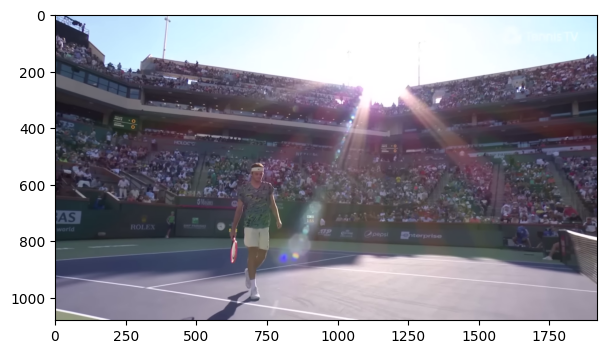

In [219]:
plot_frame(q_img, size=(7,7))

(<Figure size 700x700 with 1 Axes>, <Axes: >)

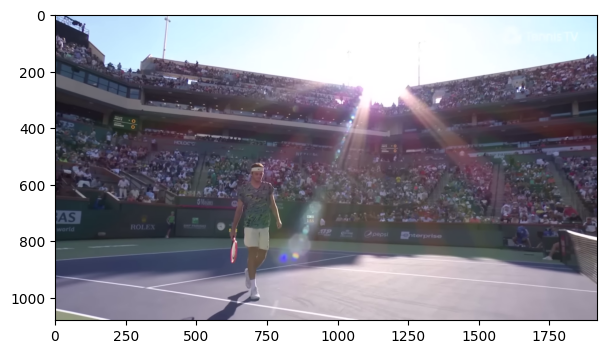

In [220]:
plot_frame(q_img, size=(7,7))

(<Figure size 700x700 with 1 Axes>, <Axes: >)

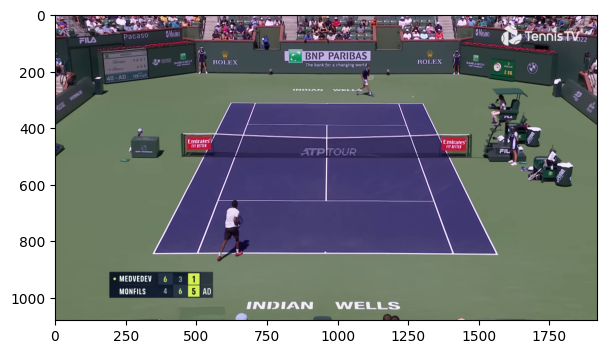

In [156]:
plot_frame(t_img, size=(7,7))

### Compare all frames

In [138]:
d_frames_confidence = {}
for idx, q_frame_num in tqdm.tqdm(enumerate(l_q_frames)):

    # Load query frame
    # q_img = capture_frame(q_cap, q_frame_num)
    q_img_rgb = base[idx].numpy()
    q_img = cv2.cvtColor(q_img_rgb, cv2.COLOR_RGB2BGR)

    # Generate patches
    patches_q_img = generate_patches_of_image(q_img, fs)

    # Bhattacharyya coefficients (BC)
    l_bc = []
    for idx in range(len(patches_q_img)):
        bc = patch_similarity_on_template(patches_q_img[idx], l_t_hist[idx])
        l_bc.append(bc)

    # Get confidence
    confidence = get_bc_conf(l_bc)

    # Persist it 
    d_frames_confidence[q_frame_num] = confidence

510it [00:00, 529.48it/s]


In [145]:
len(l_q_frames)

510

In [149]:
254 / 60

4.233333333333333

In [139]:
# Convert the dictionary to a DataFrame
df_conf = pd.DataFrame(list(d_frames_confidence.items()), columns=['frame_num', 'confidence'])

In [221]:
df_conf.tail()

frame_num  confidence
505      15150           0
506      15180           0
507      15210           0
508      15240           0
509      15270           0

In [176]:
df_cut.head(50)

frame_num  confidence
44        1320           5
45        1350           0
46        1380           0
47        1410           0
48        1440           0
49        1470           0
50        1500           0
51        1530           0
52        1560           0
53        1590           2
54        1620           2
55        1650           2
56        1680           2
57        1710           2
58        1740           2
76        2280           3
77        2310           0
78        2340           0
79        2370           0
80        2400           0
81        2430           0
82        2460           0
108       3240           3
109       3270           0
110       3300           0
111       3330           0
112       3360           0
113       3390           0
114       3420           0
115       3450           0
116       3480           0
117       3510           0
118       3540           0
119       3570           0
120       3600           0
121       3630           0
122       3660           0
123       3690           0
124       3720           0
125       3750           0
126       3780           0
127       3810           0
128       3840           0
129       3870           0
130       3900           2
131       3930           2
132       3960           2
133       3990           2
134       4020           2
135       4050           2

In [141]:
# Create a mask to identify rows where confidence > 2
confidence_mask = df_conf['confidence'] > 2

# Use the shift function to compare consecutive rows
consecutive_mask = confidence_mask & confidence_mask.shift(-1)

# Extract frame_num values where all consecutive rows have confidence > 2
df_conf_final = df_conf.loc[consecutive_mask].copy()

# Deleted scenes
df_cut = df_conf.loc[~consecutive_mask].copy()

In [143]:
df_conf_final.sort_values("confidence")

frame_num  confidence
249       7470           3
250       7500           3
75        2250           3
74        2220           3
73        2190           3
..         ...         ...
244       7320           8
245       7350           8
246       7380           8
239       7170           8
440      13200           8

[271 rows x 2 columns]

### Make Video Loading more efficient with Pytorch

In [96]:
from torchvision.io import VideoReader
import itertools
from PIL import Image
import torch

In [31]:
# stream indicates if reading from audio or video
reader = VideoReader(q_path, stream='video')

In [72]:
# Get info of 1 frame
reader.seek(0)
frame = next(reader)
tensor_frame = frame["data"].permute(1,2,0)
H, W, C = tensor_frame.shape

/opt/conda/lib/python3.10/site-packages/torchvision/io/video_reader.py:245: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


In [129]:
# Test on different timepoints
num_timepoints = len(l_q_secs)

In [130]:
%%time
# Create base tensor of type uint8
base = torch.zeros(num_timepoints, H, W, C, dtype=torch.uint8)

idx_base = -1
for tt in tqdm.tqdm(l_q_secs):
    idx_base += 1
    reader.seek(tt)
    frame = next(reader)
    
    # Convert tensor_frame to uint8, permute dimensions and insert into the base tensor
    base[idx_base] = frame["data"].permute(1, 2, 0).to(torch.uint8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:04<00:00, 107.36it/s]

CPU times: user 18.5 s, sys: 1.46 s, total: 19.9 s
Wall time: 5.15 s


In [137]:
cv2.cvtColor(tensor_frame_uint8, cv2.COLOR_RGB2BGR)

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [98]:
l_test

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [126]:
bb = base[0].numpy()
# bb = bb.astype(np.uint8)

In [127]:
base_rgb = cv2.cvtColor(bb, cv2.COLOR_RGB2BGR)

(<Figure size 1400x1100 with 1 Axes>, <Axes: >)

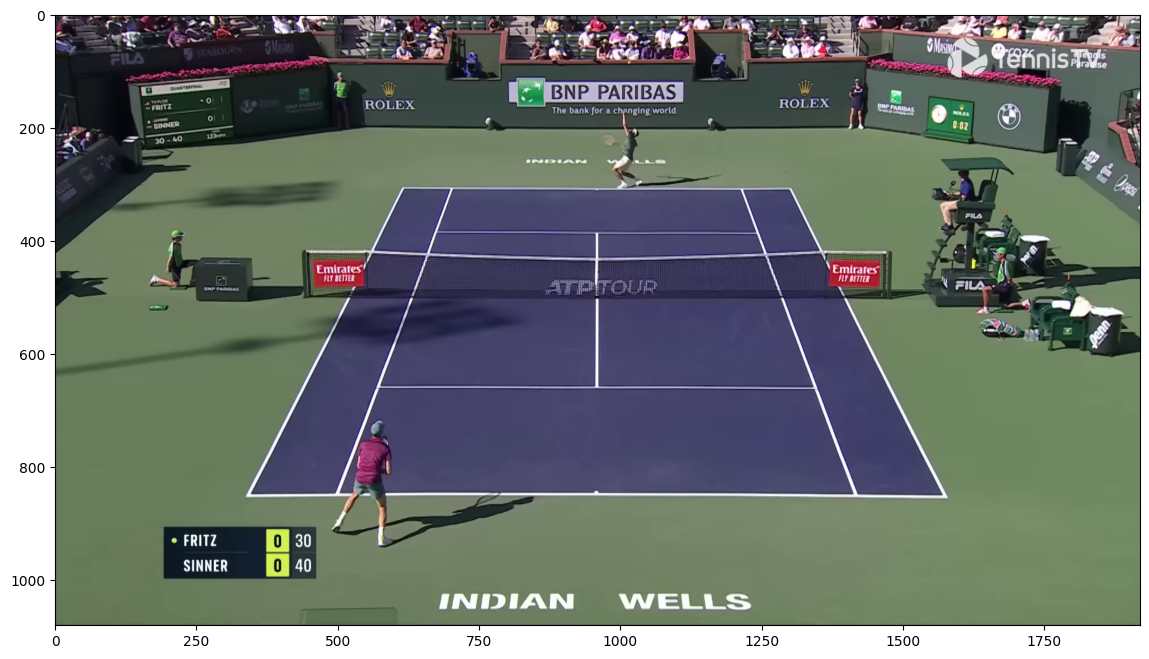

In [128]:
plot_frame(base_rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 1400x1100 with 1 Axes>, <Axes: >)

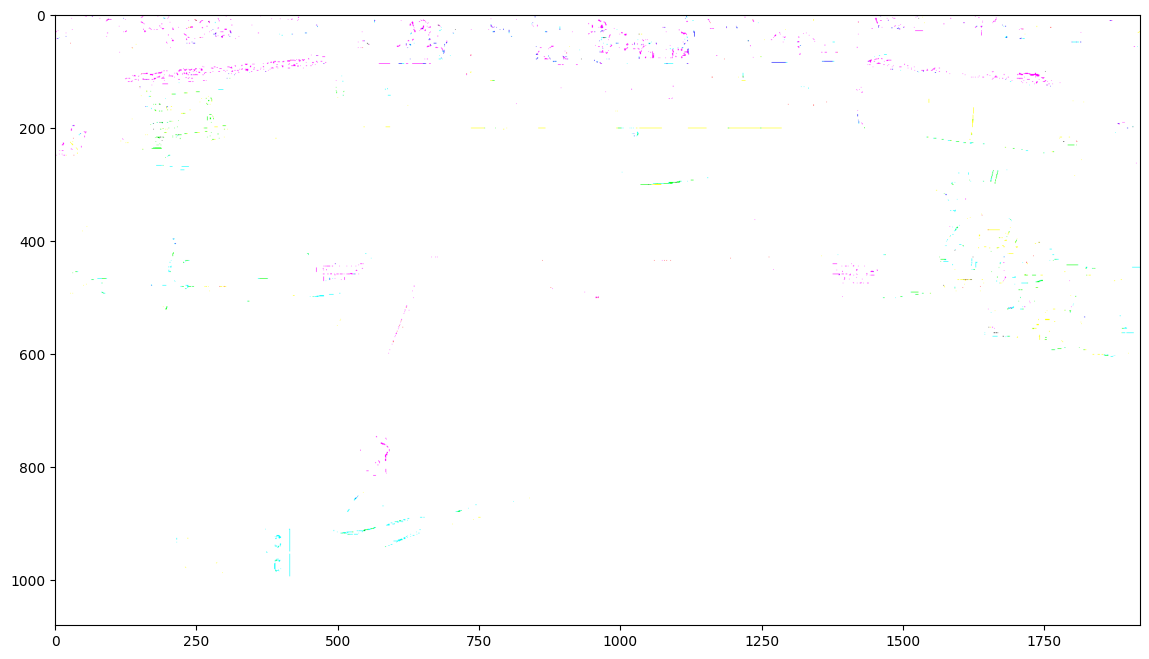

In [107]:
plot_frame(base[1].numpy())

In [ ]:
# Create a sample tensor (replace this with your actual tensor)
n_pool = len(l_test)
pool_frames = torch.zeros(n_pool, 3, 1080, 1920)

# Generate or obtain rand_tensor (replace this with your actual tensor)
rand_tensor = torch.randn(3, 1080, 1920)

# Choose the row you want to replace (replace 'row_index' with the desired row index)
row_index = 2  # Replace with your desired row index

# Check if the dimensions of rand_tensor match the dimensions of the row you want to replace
if original_tensor.shape[1:] == rand_tensor.shape:
    # Replace the row
    original_tensor[row_index] = rand_tensor
else:
    print("Dimensions of rand_tensor do not match the dimensions of the row to be replaced.")


In [69]:
l_q_secs

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,

In [63]:
%%time
reader.seek(35)

CPU times: user 131 µs, sys: 21 µs, total: 152 µs
Wall time: 201 µs


In [65]:
%%time
reader.seek(35.5)

CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.44 ms


In [64]:
%%time
ff = next(reader)

CPU times: user 25.9 ms, sys: 3.96 ms, total: 29.9 ms
Wall time: 12.6 ms


In [37]:
%%time
frames = []
for frame in itertools.islice(reader.seek(2), 10):
    frames.append(frame['data'])

CPU times: user 348 ms, sys: 59.6 ms, total: 408 ms
Wall time: 128 ms


/opt/conda/lib/python3.10/site-packages/torchvision/io/video_reader.py:245: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


In [59]:
frame

{'data': tensor([[[ 75,  73,  73,  ..., 149, 138, 128],
          [ 74,  72,  72,  ..., 161, 152, 142],
          [ 72,  70,  70,  ..., 172, 163, 153],
          ...,
          [ 99,  99,  99,  ..., 108, 108, 108],
          [ 99,  99,  99,  ..., 108, 108, 108],
          [ 99,  99,  99,  ..., 108, 108, 108]],
 
         [[ 71,  69,  69,  ..., 127, 112, 102],
          [ 70,  68,  68,  ..., 139, 126, 116],
          [ 68,  66,  66,  ..., 148, 132, 122],
          ...,
          [120, 120, 120,  ..., 132, 132, 132],
          [120, 120, 120,  ..., 132, 132, 132],
          [120, 120, 120,  ..., 132, 132, 132]],
 
         [[ 80,  78,  78,  ..., 132, 118, 108],
          [ 79,  77,  77,  ..., 144, 132, 122],
          [ 77,  75,  75,  ..., 154, 140, 130],
          ...,
          [ 86,  86,  86,  ...,  94,  94,  94],
          [ 86,  86,  86,  ...,  94,  94,  94],
          [ 86,  86,  86,  ...,  94,  94,  94]]], dtype=torch.uint8),
 'pts': 0.15}

In [40]:
frames[0].shape

torch.Size([3, 1080, 1920])

In [33]:
meta = reader.get_metadata()

In [55]:
xx = frames[9]

In [56]:
# Create a PIL image from the NumPy array
pil_image = Image.fromarray(xx.numpy().transpose(1, 2, 0))  # Assuming channel dimension is the last dimension

In [57]:
# Convert the image from RGB to BGR format
bgr_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

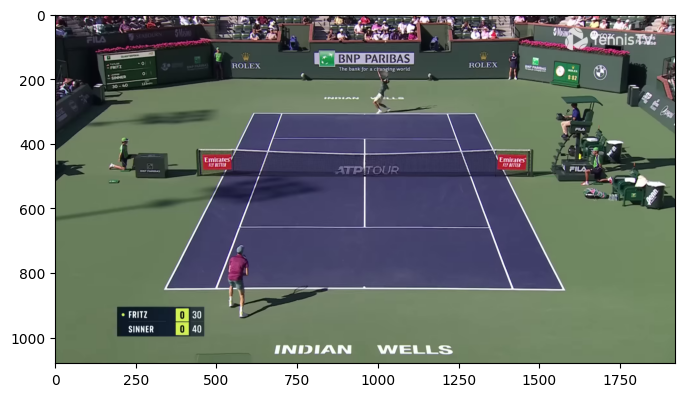

In [58]:
plot_frame(bgr_image, size=(8,8))

(<Figure size 800x800 with 1 Axes>, <Axes: >)

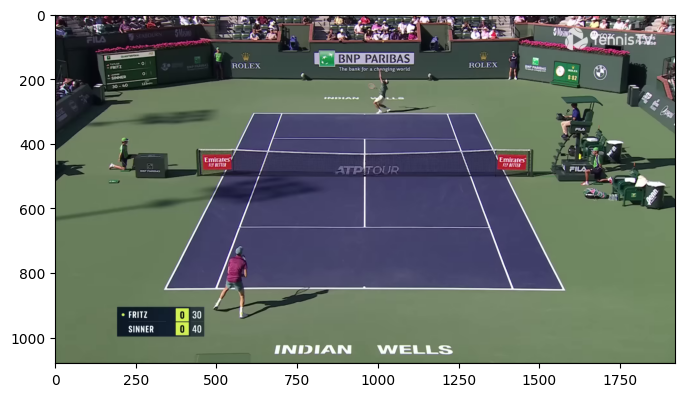

In [50]:
plot_frame(bgr_image, size=(8,8))

In [30]:
import cv2  # still used to save images out
import os
import numpy as np
from decord import VideoReader
from decord import cpu, gpu

In [31]:
vr = VideoReader(q_path, ctx=cpu(0))

In [34]:
%%time
frames = vr.get_batch([1, 30, 60])

DECORDError: [23:39:51] /github/workspace/src/video/ffmpeg/threaded_decoder.cc:104: Check failed: run_.load()

In [ ]:
ffmpeg -i "jGAMZKj6Ceo.mp4" -vf "select=gte(n\,9),setpts=PTS-STARTPTS" -frames:v 1 ../tmp_images/frame_10.png

In [37]:
%%time
os.system("""ffmpeg -i "videos/jGAMZKj6Ceo.mp4" -vf "select=gte(n\,9),setpts=PTS-STARTPTS" -frames:v 1 tmp_images/frame_1.png""")

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: 
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /  3.  9.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'videos/jGAMZKj6Ceo.mp4':
  Metadata:
    major_brand     : dash
    minor_version   : 0
    compatible_brands: iso6mp41
    creation_time   : 2023-08-23T20:59:34.000000Z
  Duration: 00:04:14.52, start: 0.000000, bitrate: 3175 kb/s
  Stream #0:0(und): Video: vp9 (Profile 0) (vp09 / 0x39307076), yuv420p(tv, bt709), 1920x1080, 3169 kb/s, 60.01 fps, 60 tbr, 1k tbn, 1k tbc (default)
    Metadata:
      creation_time   : 2023-08-23T20:59:34.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 08/23/2023.
      vendor_i

CPU times: user 4.92 ms, sys: 6.85 ms, total: 11.8 ms
Wall time: 294 ms


frame=    1 fps=0.0 q=-0.0 Lsize=N/A time=00:00:00.01 bitrate=N/A speed=0.0874x    
video:1338kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown


0

AttributeError: 'ImportError' object has no attribute 'open'

In [ ]:


# stream indicates if reading from audio or video
reader = VideoReader(q_path, stream='video')

In [ ]:

# can change the stream after construction
# via reader.set_current_stream

# to read all frames in a video starting at 2 seconds
for frame in reader.seek(2):
    # frame is a dict with "data" and "pts" metadata
    print(frame["data"], frame["pts"])

# because reader is an iterator you can combine it with
# itertools
from itertools import takewhile, islice
# read 10 frames starting from 2 seconds
for frame in islice(reader.seek(2), 10):
    pass
    
# or to return all frames between 2 and 5 seconds
for frame in takewhile(lambda x: x["pts"] < 5, reader.seek(2)):
    pass

In [818]:


# List of frame numbers to load
frame_numbers = [0, 10, 20]  # Modify this list as needed

# Create a VideoFrameDataset
video_dataset = video_utils.VideoFrameDataset(q_path, frame_indices=frame_numbers, num_segments=1, transform=None)



AttributeError: module 'torchvision.datasets.video_utils' has no attribute 'VideoFrameDataset'

In [ ]:
# Create a DataLoader to iterate through the frames
data_loader = torch.utils.data.DataLoader(video_dataset, batch_size=len(frame_numbers), shuffle=False, num_workers=0)

# Iterate through the DataLoader to get the frames
for batch in data_loader:
    frames = batch